# PNA Demo Notebook

In [1]:
import numpy as np
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import pandas as pd

import datetime as dt
import metpy

## Graphs of NOAA Calculated PNA Index Values

In [2]:
#Import CSV file with the PNA index values
pna_data_ts = pd.read_csv('PNA_Data_TS.csv')

## Plot Raw Values From CSV

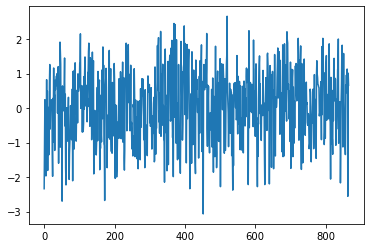

In [3]:
plt.plot(pna_data_ts['Value'])

### It Could Look Better... Let's Clean it up.

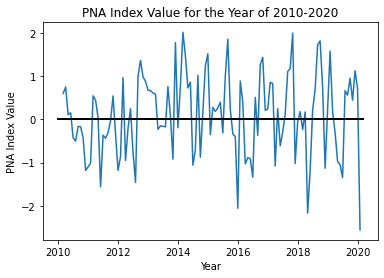

In [4]:
plt.plot(pna_data_ts['Value'][-122:-2])

plt.rcParams["font.family"] = "Serif"

plt.xticks(np.arange(742,874,24), np.arange(2010, 2022, 2))
plt.xlabel('Year')
plt.ylabel('PNA Index Value')
plt.title('PNA Index Value for the Year of 2010-2020')

plt.plot([742,864], [0, 0], 'k-', lw=2)

## Plot Standardized 500 Height Anomolies

Information is calculated using the information and methods found at http://research.jisao.washington.edu/data_sets/pna/

In [5]:
#Grab a random day to plot anomoly
z = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/pressure/hgt.2022.nc')

#Subset the day, height, and slice the lat-lon from the .nc file
z500c = z.sel(level=500.)
z500_current = z500c.sel(time='2022-03-18', lat = slice(65., 10.), lon = slice(75. + 90., 185. + 90.)).mean(dim='time')


In [6]:
#define variables and arrays
z500_mean = np.zeros((73,144))
z500_stdv = 0
p1std, p2std, p3std, p4std = [], [], [], []
p1avg, p2avg, p3avg, p4avg = [], [], [], []

#Calculate the daily mean and the standard deviation for the data.
for year in np.arange(1991,2021,1):
    z = xr.open_dataset(f'https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs/pressure/hgt.{year}.nc')
    z500 = z.sel(level=500., lat = slice(65., 10.), lon = slice(75. + 90., 185. + 90.))
    z500 = z.sel(level=500.)
    
    p1std.append(np.std(z.sel(level=500., lat = 20., lon = 160. + 90.)['hgt'].values))
    p2std.append(np.std(z.sel(level=500., lat = 45., lon = 165. + 90.)['hgt'].values))
    p3std.append(np.std(z.sel(level=500., lat = 55., lon = 115. + 90.)['hgt'].values))
    p4std.append(np.std(z.sel(level=500., lat = 30., lon = 85. + 90.)['hgt'].values))
    
    p1avg.append(np.mean(z.sel(level=500., lat = 20., lon = 160. + 90.)['hgt'].values))
    p2avg.append(np.mean(z.sel(level=500., lat = 45., lon = 165. + 90.)['hgt'].values))
    p3avg.append(np.mean(z.sel(level=500., lat = 55., lon = 115. + 90.)['hgt'].values))
    p4avg.append(np.mean(z.sel(level=500., lat = 30., lon = 85. + 90.)['hgt'].values))
                
    
    z500_mean = z500['hgt'].mean('time') + z500_mean
    z500_stdv = np.std(z500['hgt']).data + z500_stdv
    
z500_mean = z500_mean / 30
z500_stdv = z500_stdv / 30

p1_std = np.mean(p1std)
p1_avg = np.mean(p1avg)
p2_std = np.mean(p2std)
p2_avg = np.mean(p2avg)
p3_std = np.mean(p3std)
p3_avg = np.mean(p3avg)
p4_std = np.mean(p4std)
p4_avg = np.mean(p4avg)


In [7]:
#Calculate the standized anomoly.
anom = z500_current['hgt'] - z500_mean
std_anom = anom / z500_stdv


### Show Plot

/programs/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


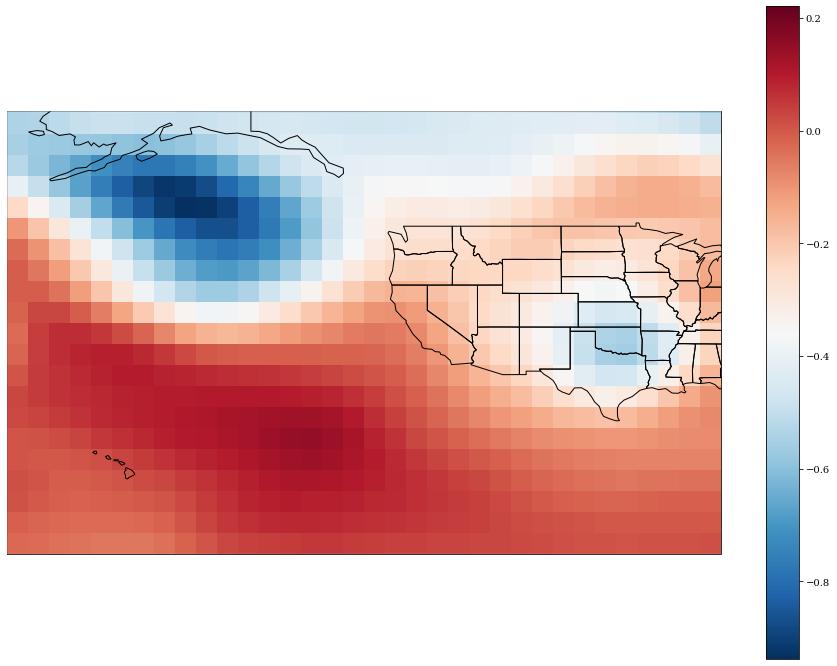

In [8]:
fig = plt.figure()
fig.set_size_inches(16,12)
ax1 = fig.add_subplot(111, projection = cartopy.crs.PlateCarree())
c = ax1.pcolormesh(z500_current.lon, z500_current.lat, std_anom, transform=cartopy.crs.PlateCarree(), zorder=12,  cmap='RdBu_r')
ax1.add_feature(cartopy.feature.STATES, facecolor='none', edgecolor='black', zorder = 19)
plt.colorbar(c)
ax1.set_extent([-170, -85, 10, 55])

## Calculate the PNA Index Value From March 18th

The equation used is 

$$
PNA = 0.25 * (Z[20^{\circ}N, 160^{\circ}W] - Z[45^{\circ}N, 165^{\circ}W] + Z[55^{\circ}N, 115^{\circ}W] - Z[30^{\circ}N, 85^{\circ}W])
$$

with each component being standardized 500 hPa geopotential height values.

In [9]:
#Get the height values for the different points
p1 = z500c.sel(time='2022-03-18', lat = 20., lon = 160. + 90.)['hgt'].values[0]
p2 = z500c.sel(time='2022-03-18', lat = 45., lon = 165. + 90.)['hgt'].values[0]
p3 = z500c.sel(time='2022-03-18', lat = 55., lon = 115. + 90.)['hgt'].values[0]
p4 = z500c.sel(time='2022-03-18', lat = 30., lon = 85. + 90.)['hgt'].values[0]

In [10]:
#Calculate the components of the equation
part1 = (p1 - p1_avg) / p1_std
part2 = (p2 - p2_avg) / p2_std
part3 = (p3 - p3_avg) / p3_std
part4 = (p4 - p4_avg) / p4_std

In [11]:
#Calculate the PNA index
PNA = 0.25*(part1 - part2 + part3 - part4)
print(f'The value of the PNA is {PNA} and I think that is awesome and way better than ENSO')

The value of the PNA is -0.053156912326812744 and I think that is awesome and way better than ENSO
